In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import math, os

In [2]:
def lrelu(x, rate=0.1):
    return tf.maximum(tf.minimum(x * rate, 0), x)

def conv2d_lrelu(inputs, num_outputs, kernel_size, stride):
    conv = tf.contrib.layers.convolution2d(inputs, num_outputs, kernel_size, stride,
                                           weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                           activation_fn=tf.identity)
    conv = lrelu(conv)
    return conv

def conv2d_t_relu(inputs, num_outputs, kernel_size, stride):
    conv = tf.contrib.layers.convolution2d_transpose(inputs, num_outputs, kernel_size, stride,
                                                     weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                                     activation_fn=tf.identity)
    conv = tf.nn.relu(conv)
    return conv

def fc_lrelu(inputs, num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                           weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                           activation_fn=tf.identity)
    fc = lrelu(fc)
    return fc

def fc_relu(inputs, num_outputs):
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                           weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                           activation_fn=tf.identity)
    fc = tf.nn.relu(fc)
    return fc

In [3]:
def encoder(x, z_dim):
    with tf.variable_scope('encoder'):
        conv1 = conv2d_lrelu(x, 64, 4, 2)
        conv2 = conv2d_lrelu(conv1, 128, 4, 2)
        conv2 = tf.reshape(conv2, [-1, np.prod(conv2.get_shape().as_list()[1:])])
        fc1 = fc_lrelu(conv2, 512)
        mean = tf.contrib.layers.fully_connected(fc1, z_dim, activation_fn=tf.identity)
        stddev = tf.contrib.layers.fully_connected(fc1, z_dim, activation_fn=tf.sigmoid)
        stddev = tf.maximum(stddev, 0.001)
        pred = mean + tf.multiply(stddev, tf.random_normal(tf.stack([tf.shape(x)[0], z_dim])))
        return mean, stddev, pred

In [4]:
def decoder(z, reuse=False):
    with tf.variable_scope('decoder') as vs:
        if reuse:
            vs.reuse_variables()
        fc1 = fc_relu(z, 1024)
        fc2 = fc_relu(fc1, 7*7*128)
        fc2 = tf.reshape(fc2, tf.stack([tf.shape(fc2)[0], 7, 7, 128]))
        conv1 = conv2d_t_relu(fc2, 64, 4, 2)
        output = tf.contrib.layers.convolution2d_transpose(conv1, 1, 4, 2, activation_fn=tf.sigmoid)
        return output

In [5]:
z_dim = 10
train_x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
train_mean, train_stddev, train_z = encoder(train_x, z_dim)
train_xr = decoder(train_z)

In [6]:
gen_z = tf.placeholder(tf.float32, shape=[None, z_dim])
gen_x = decoder(gen_z, reuse=True)

In [7]:
loss_nll = tf.reduce_mean(tf.square(train_xr - train_x))

In [8]:
elbo_coeff = 0.001
loss_elbo = elbo_coeff * tf.reduce_mean(-tf.log(train_stddev) + 0.5 * tf.square(train_stddev) + 0.5 * tf.square(train_mean) - 0.5)

In [9]:
loss = loss_nll + loss_elbo
trainer = tf.train.AdamOptimizer(1e-3).minimize(loss)

In [10]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist_data')

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [11]:
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

In [12]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
batch_size = 200
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Negative log likelihood is 0.231273, elbo loss is 0.000317


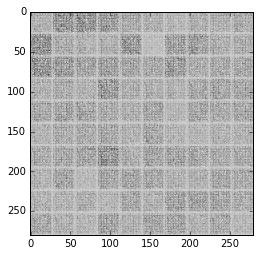

Negative log likelihood is 0.043404, elbo loss is 0.001937
Negative log likelihood is 0.022579, elbo loss is 0.002612
Negative log likelihood is 0.019325, elbo loss is 0.002689
Negative log likelihood is 0.016306, elbo loss is 0.002696
Negative log likelihood is 0.015056, elbo loss is 0.002701


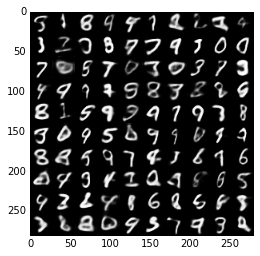

Negative log likelihood is 0.014536, elbo loss is 0.002687
Negative log likelihood is 0.012379, elbo loss is 0.002749
Negative log likelihood is 0.013843, elbo loss is 0.002695
Negative log likelihood is 0.012585, elbo loss is 0.002740
Negative log likelihood is 0.012535, elbo loss is 0.002812


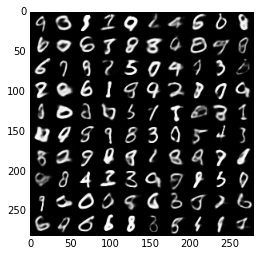

Negative log likelihood is 0.012170, elbo loss is 0.002799
Negative log likelihood is 0.011982, elbo loss is 0.002744
Negative log likelihood is 0.011969, elbo loss is 0.002790
Negative log likelihood is 0.011932, elbo loss is 0.002831
Negative log likelihood is 0.012136, elbo loss is 0.002770


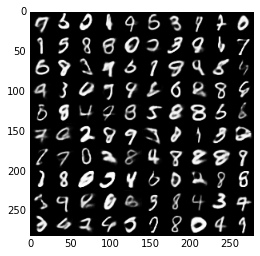

Negative log likelihood is 0.011472, elbo loss is 0.002811
Negative log likelihood is 0.011239, elbo loss is 0.002765
Negative log likelihood is 0.010871, elbo loss is 0.002770
Negative log likelihood is 0.011024, elbo loss is 0.002751
Negative log likelihood is 0.010203, elbo loss is 0.002801


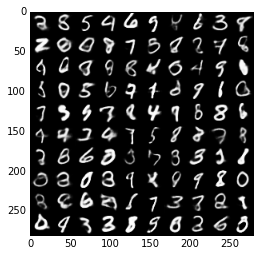

Negative log likelihood is 0.011141, elbo loss is 0.002803
Negative log likelihood is 0.011434, elbo loss is 0.002833
Negative log likelihood is 0.010772, elbo loss is 0.002877
Negative log likelihood is 0.010001, elbo loss is 0.002843
Negative log likelihood is 0.010002, elbo loss is 0.002819


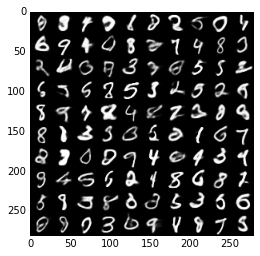

Negative log likelihood is 0.010651, elbo loss is 0.002898
Negative log likelihood is 0.010378, elbo loss is 0.002787
Negative log likelihood is 0.010589, elbo loss is 0.002872
Negative log likelihood is 0.010069, elbo loss is 0.002851
Negative log likelihood is 0.009802, elbo loss is 0.002854


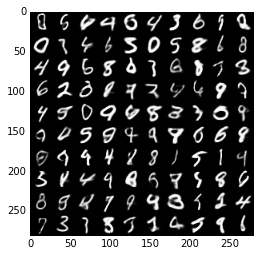

Negative log likelihood is 0.009433, elbo loss is 0.002832
Negative log likelihood is 0.010117, elbo loss is 0.002829
Negative log likelihood is 0.009481, elbo loss is 0.002828
Negative log likelihood is 0.009981, elbo loss is 0.002854
Negative log likelihood is 0.008669, elbo loss is 0.002810


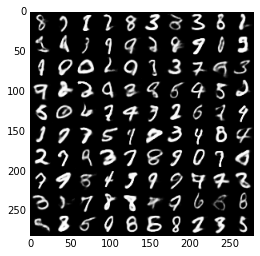

Negative log likelihood is 0.009343, elbo loss is 0.002821
Negative log likelihood is 0.009269, elbo loss is 0.002843
Negative log likelihood is 0.009311, elbo loss is 0.002798
Negative log likelihood is 0.009231, elbo loss is 0.002877
Negative log likelihood is 0.009418, elbo loss is 0.002855


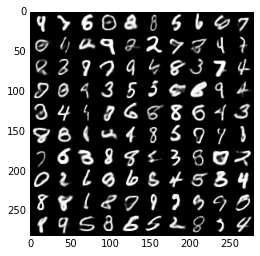

Negative log likelihood is 0.009413, elbo loss is 0.002830
Negative log likelihood is 0.008789, elbo loss is 0.002848
Negative log likelihood is 0.009120, elbo loss is 0.002879
Negative log likelihood is 0.008707, elbo loss is 0.002904
Negative log likelihood is 0.008375, elbo loss is 0.002829


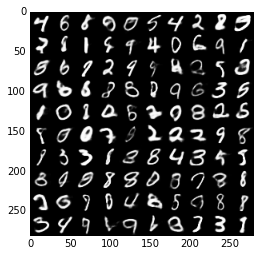

Negative log likelihood is 0.009106, elbo loss is 0.002861
Negative log likelihood is 0.009319, elbo loss is 0.002893
Negative log likelihood is 0.008998, elbo loss is 0.002918
Negative log likelihood is 0.009010, elbo loss is 0.002924
Negative log likelihood is 0.008426, elbo loss is 0.002881


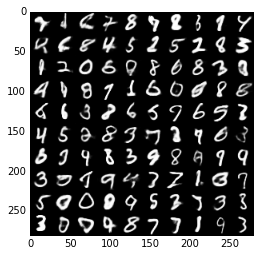

Negative log likelihood is 0.008717, elbo loss is 0.002834
Negative log likelihood is 0.008574, elbo loss is 0.002892
Negative log likelihood is 0.008995, elbo loss is 0.002875
Negative log likelihood is 0.008439, elbo loss is 0.002816
Negative log likelihood is 0.008334, elbo loss is 0.002851


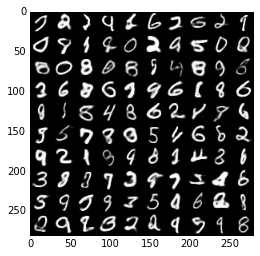

Negative log likelihood is 0.009241, elbo loss is 0.002890
Negative log likelihood is 0.009426, elbo loss is 0.002914
Negative log likelihood is 0.008853, elbo loss is 0.002849
Negative log likelihood is 0.007966, elbo loss is 0.002865
Negative log likelihood is 0.008774, elbo loss is 0.002863


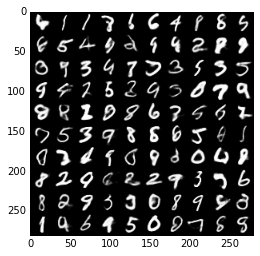

Negative log likelihood is 0.009036, elbo loss is 0.002817
Negative log likelihood is 0.008494, elbo loss is 0.002820
Negative log likelihood is 0.008599, elbo loss is 0.002857
Negative log likelihood is 0.008450, elbo loss is 0.002854
Negative log likelihood is 0.008625, elbo loss is 0.002893


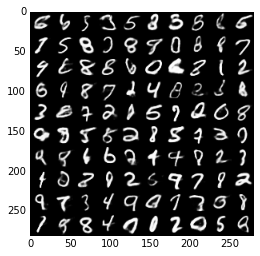

Negative log likelihood is 0.008084, elbo loss is 0.002878
Negative log likelihood is 0.008439, elbo loss is 0.002870
Negative log likelihood is 0.008320, elbo loss is 0.002847
Negative log likelihood is 0.007602, elbo loss is 0.002832
Negative log likelihood is 0.008412, elbo loss is 0.002883


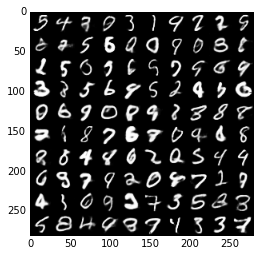

Negative log likelihood is 0.008689, elbo loss is 0.002946
Negative log likelihood is 0.008339, elbo loss is 0.002904
Negative log likelihood is 0.008044, elbo loss is 0.002866
Negative log likelihood is 0.008277, elbo loss is 0.002955
Negative log likelihood is 0.008386, elbo loss is 0.002846


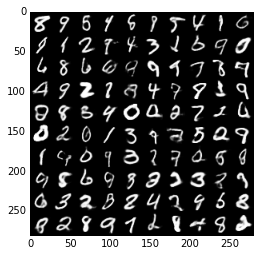

Negative log likelihood is 0.008283, elbo loss is 0.002943
Negative log likelihood is 0.007950, elbo loss is 0.002858
Negative log likelihood is 0.007880, elbo loss is 0.002830
Negative log likelihood is 0.008107, elbo loss is 0.002833
Negative log likelihood is 0.007668, elbo loss is 0.002837


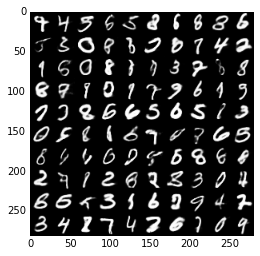

Negative log likelihood is 0.008077, elbo loss is 0.002848
Negative log likelihood is 0.008205, elbo loss is 0.002866
Negative log likelihood is 0.007782, elbo loss is 0.002888
Negative log likelihood is 0.007633, elbo loss is 0.002865
Negative log likelihood is 0.008043, elbo loss is 0.002918


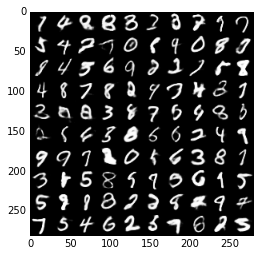

Negative log likelihood is 0.007847, elbo loss is 0.002861
Negative log likelihood is 0.008164, elbo loss is 0.002887
Negative log likelihood is 0.007824, elbo loss is 0.002902
Negative log likelihood is 0.007841, elbo loss is 0.002918
Negative log likelihood is 0.008167, elbo loss is 0.002910


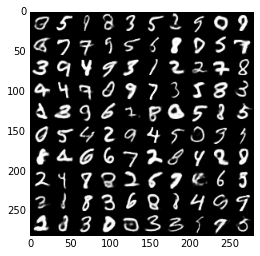

Negative log likelihood is 0.008012, elbo loss is 0.002922
Negative log likelihood is 0.007736, elbo loss is 0.002903
Negative log likelihood is 0.007435, elbo loss is 0.002877
Negative log likelihood is 0.007487, elbo loss is 0.002856
Negative log likelihood is 0.007872, elbo loss is 0.002852


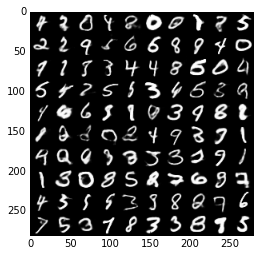

Negative log likelihood is 0.008257, elbo loss is 0.002905
Negative log likelihood is 0.008241, elbo loss is 0.002857
Negative log likelihood is 0.007164, elbo loss is 0.002883
Negative log likelihood is 0.007546, elbo loss is 0.002850
Negative log likelihood is 0.007159, elbo loss is 0.002898


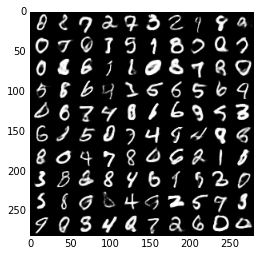

Negative log likelihood is 0.007872, elbo loss is 0.002898
Negative log likelihood is 0.007168, elbo loss is 0.002900
Negative log likelihood is 0.007393, elbo loss is 0.002890
Negative log likelihood is 0.007696, elbo loss is 0.002855
Negative log likelihood is 0.007389, elbo loss is 0.002838


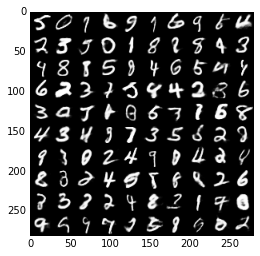

Negative log likelihood is 0.007559, elbo loss is 0.002851
Negative log likelihood is 0.007843, elbo loss is 0.002868
Negative log likelihood is 0.007511, elbo loss is 0.002913
Negative log likelihood is 0.007605, elbo loss is 0.002867
Negative log likelihood is 0.007169, elbo loss is 0.002850


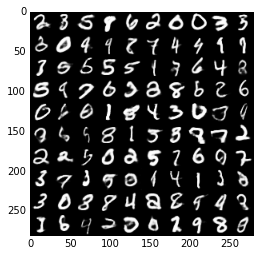

Negative log likelihood is 0.007540, elbo loss is 0.002884
Negative log likelihood is 0.007254, elbo loss is 0.002907
Negative log likelihood is 0.007481, elbo loss is 0.002858
Negative log likelihood is 0.007262, elbo loss is 0.002878
Negative log likelihood is 0.007580, elbo loss is 0.003000


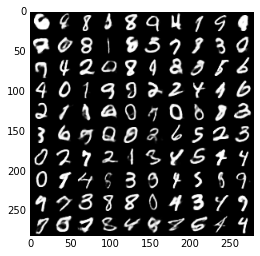

Negative log likelihood is 0.006800, elbo loss is 0.002916
Negative log likelihood is 0.007472, elbo loss is 0.002858
Negative log likelihood is 0.007224, elbo loss is 0.002859
Negative log likelihood is 0.006526, elbo loss is 0.002907
Negative log likelihood is 0.007263, elbo loss is 0.002853


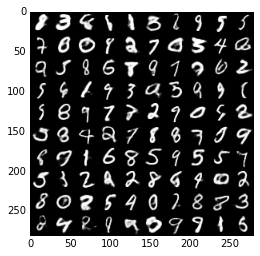

Negative log likelihood is 0.007120, elbo loss is 0.002849
Negative log likelihood is 0.007255, elbo loss is 0.002921
Negative log likelihood is 0.006858, elbo loss is 0.002840
Negative log likelihood is 0.006515, elbo loss is 0.002867
Negative log likelihood is 0.007631, elbo loss is 0.002855


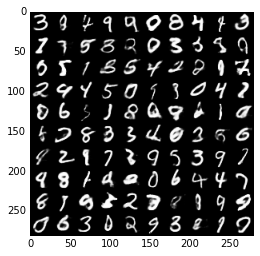

Negative log likelihood is 0.007079, elbo loss is 0.002882
Negative log likelihood is 0.007059, elbo loss is 0.002979
Negative log likelihood is 0.007814, elbo loss is 0.002921
Negative log likelihood is 0.007487, elbo loss is 0.002863
Negative log likelihood is 0.007602, elbo loss is 0.002856


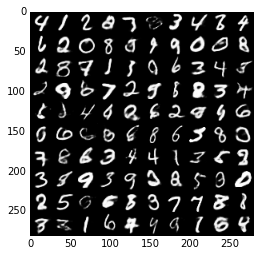

Negative log likelihood is 0.007482, elbo loss is 0.002887
Negative log likelihood is 0.007256, elbo loss is 0.002906
Negative log likelihood is 0.007100, elbo loss is 0.002856
Negative log likelihood is 0.007241, elbo loss is 0.002885
Negative log likelihood is 0.006883, elbo loss is 0.002909


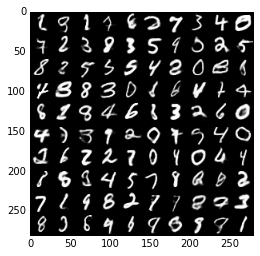

Negative log likelihood is 0.006627, elbo loss is 0.002897
Negative log likelihood is 0.006922, elbo loss is 0.002876
Negative log likelihood is 0.006947, elbo loss is 0.002913
Negative log likelihood is 0.007496, elbo loss is 0.002909
Negative log likelihood is 0.007408, elbo loss is 0.002866


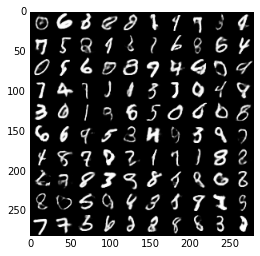

Negative log likelihood is 0.006361, elbo loss is 0.002864
Negative log likelihood is 0.006870, elbo loss is 0.002893
Negative log likelihood is 0.006837, elbo loss is 0.002912
Negative log likelihood is 0.006705, elbo loss is 0.002866
Negative log likelihood is 0.007230, elbo loss is 0.002906


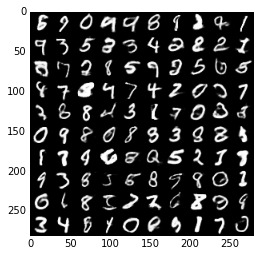

Negative log likelihood is 0.006581, elbo loss is 0.002917
Negative log likelihood is 0.006760, elbo loss is 0.002922
Negative log likelihood is 0.006999, elbo loss is 0.002863
Negative log likelihood is 0.006556, elbo loss is 0.002872
Negative log likelihood is 0.006972, elbo loss is 0.002847


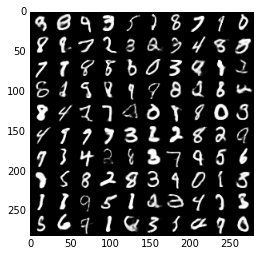

Negative log likelihood is 0.007016, elbo loss is 0.002939
Negative log likelihood is 0.007116, elbo loss is 0.002949
Negative log likelihood is 0.006936, elbo loss is 0.002927
Negative log likelihood is 0.006640, elbo loss is 0.002956
Negative log likelihood is 0.006822, elbo loss is 0.002897


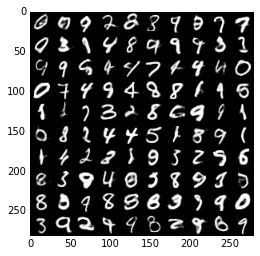

Negative log likelihood is 0.006467, elbo loss is 0.002925
Negative log likelihood is 0.007435, elbo loss is 0.002896
Negative log likelihood is 0.006856, elbo loss is 0.002818
Negative log likelihood is 0.007333, elbo loss is 0.002904
Negative log likelihood is 0.006889, elbo loss is 0.002926


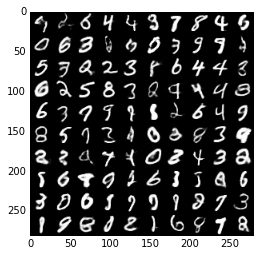

Negative log likelihood is 0.006625, elbo loss is 0.002904
Negative log likelihood is 0.006394, elbo loss is 0.002858
Negative log likelihood is 0.007146, elbo loss is 0.002921
Negative log likelihood is 0.006270, elbo loss is 0.002945
Negative log likelihood is 0.006763, elbo loss is 0.002916


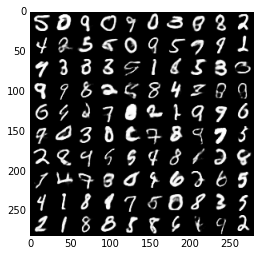

Negative log likelihood is 0.006926, elbo loss is 0.002958
Negative log likelihood is 0.006635, elbo loss is 0.002917
Negative log likelihood is 0.006466, elbo loss is 0.002897
Negative log likelihood is 0.006581, elbo loss is 0.002877
Negative log likelihood is 0.006532, elbo loss is 0.002898


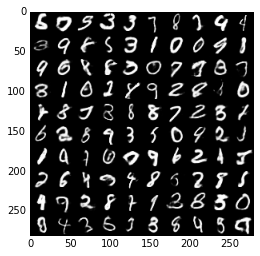

Negative log likelihood is 0.006451, elbo loss is 0.002899
Negative log likelihood is 0.006395, elbo loss is 0.002895
Negative log likelihood is 0.006300, elbo loss is 0.002863
Negative log likelihood is 0.006119, elbo loss is 0.002980
Negative log likelihood is 0.006106, elbo loss is 0.002915


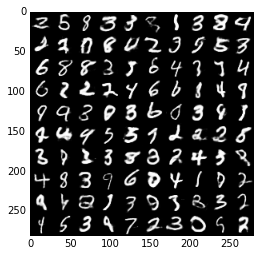

Negative log likelihood is 0.006797, elbo loss is 0.002937
Negative log likelihood is 0.006261, elbo loss is 0.002950
Negative log likelihood is 0.006920, elbo loss is 0.002915
Negative log likelihood is 0.006208, elbo loss is 0.002891
Negative log likelihood is 0.006654, elbo loss is 0.002923


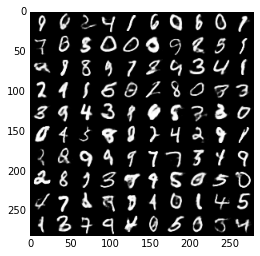

Negative log likelihood is 0.006816, elbo loss is 0.002938
Negative log likelihood is 0.006630, elbo loss is 0.002962
Negative log likelihood is 0.006482, elbo loss is 0.002916
Negative log likelihood is 0.006806, elbo loss is 0.002901
Negative log likelihood is 0.006722, elbo loss is 0.002957


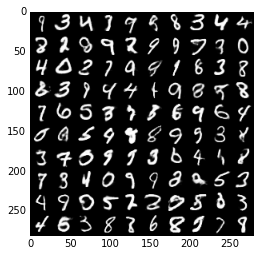

Negative log likelihood is 0.006685, elbo loss is 0.002931
Negative log likelihood is 0.005993, elbo loss is 0.002902
Negative log likelihood is 0.006219, elbo loss is 0.002938
Negative log likelihood is 0.006653, elbo loss is 0.002901
Negative log likelihood is 0.006087, elbo loss is 0.002946


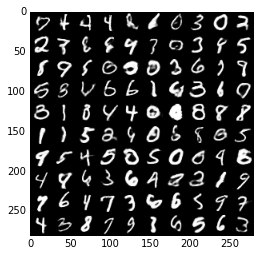

Negative log likelihood is 0.006309, elbo loss is 0.002928
Negative log likelihood is 0.005972, elbo loss is 0.002867
Negative log likelihood is 0.006242, elbo loss is 0.002910
Negative log likelihood is 0.006457, elbo loss is 0.002916
Negative log likelihood is 0.006243, elbo loss is 0.002918


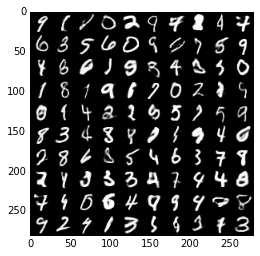

Negative log likelihood is 0.006477, elbo loss is 0.002900
Negative log likelihood is 0.006422, elbo loss is 0.002912
Negative log likelihood is 0.005705, elbo loss is 0.002885
Negative log likelihood is 0.006149, elbo loss is 0.002948


In [13]:
writer = open('log_%.6f' % elbo_coeff, 'w')
for i in range(20000):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    batch_x = batch_x.reshape(-1, 28, 28, 1)
    _, nll, elbo = sess.run([trainer, loss_nll, loss_elbo], feed_dict={train_x: batch_x})
    if i % 100 == 0:
        print("Negative log likelihood is %f, elbo loss is %f" % (nll, elbo))
        writer.write('%d %f\n' % (i, nll))
        writer.flush()
    if i % 500 == 0:
        samples = sess.run(gen_x, feed_dict={gen_z: np.random.normal(size=(100, z_dim))})
        plt.imshow(convert_to_display(samples), cmap='Greys_r')
        plt.show()
writer.close()

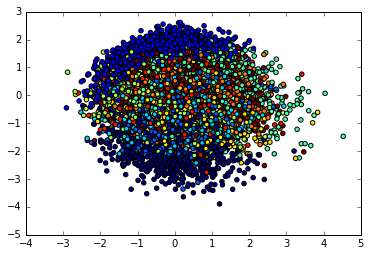

In [14]:
z_list, label_list = [], []
test_batch_size = 500
for i in range(20):
    batch_x, batch_y = mnist.test.next_batch(test_batch_size)
    batch_x = batch_x.reshape(-1, 28, 28, 1)
    z_list.append(sess.run(train_z, feed_dict={train_x: batch_x}))
    label_list.append(batch_y)
z = np.concatenate(z_list, axis=0)
label = np.concatenate(label_list)
plt.scatter(z[:, 0], z[:, 1], c=label)
plt.show()

###### 